In [96]:
import polars as pl

normalState = pl.read_csv('data/normal_state_phone.csv')
anomalyState = pl.read_csv('data/anomaly_state_phone.csv')

In [97]:
normalState.head()

Name,accelerometerIn
i64,i64
0,39
1,9
2,44
3,82
4,57


<Axes: xlabel='Name', ylabel='accelerometerIn'>

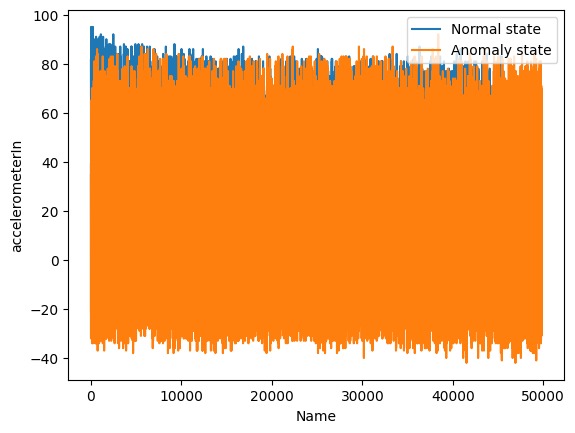

In [98]:
import seaborn as sns

sns.lineplot(data=normalState.to_pandas(), x="Name", y="accelerometerIn", label="Normal state")
sns.lineplot(data=anomalyState.to_pandas(), x="Name", y="accelerometerIn", label="Anomaly state")


In [99]:
import numpy as np

def splitTimeDataIntoBuffers(inputData, bufferLength = 200):
    numBuffers = len(inputData) // bufferLength
    print(numBuffers)

    buffersSplitted = []
    for i in range(numBuffers):
        buffer = np.array(inputData[i * bufferLength : (i + 1) * bufferLength, 1])
        if len(buffer)>0:
            buffersSplitted.append(buffer)

    return buffersSplitted

normalTimeBuffers = splitTimeDataIntoBuffers(normalState)
anomalyTimeBuffers = splitTimeDataIntoBuffers(anomalyState)


228
249


In [100]:
import numpy as np

columnsSpec = {
"acc_min": pl.Series([], dtype=pl.Int64),
"acc_max": pl.Series([], dtype=pl.Int64),
#"acc_rms": pl.Series([], dtype=pl.Float64),
#"acc_mean": pl.Series([], dtype=pl.Float64),
"class": pl.Series([], dtype=pl.Int64)
}

def calculateFeatures(inputData, targetClass):
    dfOutputFrame = pl.DataFrame(columnsSpec)

    #min, max, rms, mean
    for buf in inputData:
        acc_max = np.max(buf)
        acc_min = np.min(buf)
        acc_mean = np.mean(buf)
        acc_rms = np.sqrt(np.mean(np.square(buf)))
        
        new_row = {
            "acc_min": acc_min,
            "acc_max": acc_max,
            #"acc_rms": acc_rms,
            #"acc_mean": acc_mean,
            "class": targetClass
        }

        # Add the new row to the dataframe
        dfOutputFrame = dfOutputFrame.vstack(pl.DataFrame([new_row]))

    return dfOutputFrame

dfNormalLearnTestSet = calculateFeatures(normalTimeBuffers, 0)
dfAnomalyLearnTestSet = calculateFeatures(anomalyTimeBuffers, 1)

dfLearnTestSet = pl.DataFrame(columnsSpec)
dfLearnTestSet = dfLearnTestSet.vstack(dfNormalLearnTestSet)
dfLearnTestSet = dfLearnTestSet.vstack(dfAnomalyLearnTestSet)

In [101]:
dfLearnTestSet.columns

['acc_min', 'acc_max', 'class']

In [102]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

X = dfLearnTestSet[:, :2] 
y = dfLearnTestSet[:, 2]  

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred, pos_label=1)  # Sensitivity (Recall) for positive class
specificity = recall_score(y_test, y_pred, pos_label=0)  # Recall for the negative class = Specificity
roc_auc = roc_auc_score(y_test, y_pred)  # AUC requires predicted probabilities

print(f"Classifier used: {clf}")
print(f"Accuraccies: {accuracy}")
print(f"Sensitivities (Recall for positive class): {sensitivity}")
print(f"Specificities (Recall for negative class): {specificity}")
print(f"ROC AUCs: {roc_auc}")


Classifier used: DecisionTreeClassifier()
Accuraccies: 1.0
Sensitivities (Recall for positive class): 1.0
Specificities (Recall for negative class): 1.0
ROC AUCs: 1.0


In [107]:
predictedState = clf.predict([[-14, 83]])

print(predictedState)

[0]


d:\prz\2024-msiswil-lectures\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [109]:
from skl2onnx import convert_sklearn 
from skl2onnx.common.data_types import FloatTensorType

onnxfile = 'decisiontree-classifier.onnx'
initial_type = [('float_input', FloatTensorType([None, X.shape[1]]))]
# # Zipmap should be always turned off as it's not implemented in TF3800
onnx_model = convert_sklearn(clf, initial_types=initial_type, options={type(clf): {'zipmap':False}}, target_opset=12)
# # Export to ONNX file
with open(onnxfile, "wb") as f:
    f.write( onnx_model.SerializeToString())
f.close()


In [112]:
import onnx
onnx_model = onnx.load("decisiontree-classifier.onnx")
print(onnx_model)



ir_version: 7
producer_name: "skl2onnx"
producer_version: "1.17.0"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "float_input"
    output: "label"
    output: "probabilities"
    name: "TreeEnsembleClassifier"
    op_type: "TreeEnsembleClassifier"
    attribute {
      name: "class_ids"
      ints: 0
      ints: 0
      ints: 0
      ints: 0
      ints: 0
      ints: 0
      type: INTS
    }
    attribute {
      name: "class_nodeids"
      ints: 1
      ints: 4
      ints: 5
      ints: 8
      ints: 9
      ints: 10
      type: INTS
    }
    attribute {
      name: "class_treeids"
      ints: 0
      ints: 0
      ints: 0
      ints: 0
      ints: 0
      ints: 0
      type: INTS
    }
    attribute {
      name: "class_weights"
      floats: 1.0
      floats: 0.0
      floats: 1.0
      floats: 0.0
      floats: 1.0
      floats: 0.0
      type: FLOATS
    }
    attribute {
      name: "classlabels_int64s"
      ints: 0
      ints: 1
      type: INTS

In [122]:
import numpy
import onnxruntime as rt

X_toClassify = [[-25,77], [-33,73]]
sess = rt.InferenceSession("decisiontree-classifier.onnx")
#input_name = sess.get_inputs()[0].name
pred_onx = sess.run(None, {'float_input': np.array(X_toClassify).astype(numpy.float32)})[0]

print(pred_onx)

[0 1]
